In [135]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

dfs = pd.read_csv('survival_data.csv')
df1 = dfs.copy()
df1.head(3)

,time,event,age,treatment
0,7.483810,1,64.967142,1
1,22.360127,0,58.617357,1
2,6.562908,1,66.476885,0


In [110]:
from rpy2.robjects import pandas2ri, conversion
from rpy2.robjects.packages import importr
import rpy2.robjects as ro

rstpm2 = importr("rstpm2")
survival = importr("survival")
ggplot2 = importr("ggplot2")

with conversion.localconverter(pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df1)


R callback write-console: Failed with error:    
R callback write-console:   
R callback write-console: ‘Package ‘ggplot2’ version 4.0.0 cannot be unloaded:
 Error in unloadNamespace(package) : namespace ‘ggplot2’ is imported by ‘flexsurv’ so cannot be unloaded
’  
R callback write-console:   
R callback write-console: 
  


In [111]:
from rpy2.robjects import Formula

# Define the formula
formula = Formula('Surv(time, event) ~ age + treatment')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_df, df=3)


In [112]:
print(ro.r.summary(fp_model))


Maximum likelihood estimation

Call:
(function (formula, data, weights = NULL, subset = NULL, coxph.strata = NULL, 
    ...) 
{
    m <- match.call()
    m[[1L]] <- quote(gsm)
    m$penalised <- FALSE
    out <- eval(m, data, parent.frame())
    out@Call <- match.call()
    out
})(formula = Surv(time, event) ~ age + treatment, data = list(
    time = c(7.48381039685687, 22.3601270252418, 6.56290768656722, 
    25.7839713848249, 32.9211746476886, 9.8806616759519, 26.0923699853616, 
    6.67209455104277, 7.41347501510736, 15.4717659739793, 5.8183198942738, 
    26.5752543562231, 12.8417198875872, 2.76238980203114, 16.1383683068996, 
    39.5440571465394, 14.6027029563604, 15.233956954902, 4.04596415256261, 
    20.1490089382581, 8.67622574932543, 22.3808714988439, 3.35089028507582, 
    27.309919406079, 13.7623393946028, 5.05078122417244, 6.62623363709242, 
    4.61514717728804, 16.9133266758975, 24.3530959409468, 30.3126468875489, 
    8.27965090257324, 8.74193136302063, 16.470557180958

In [188]:
# Predict survival probabilities
# newdata must be a data.frame in R
new_data = pandas2ri.py2rpy(pd.DataFrame({
    "age": [60, 50],
    "treatment": [1, 0]
}))

# Import the base R predict function
r_predict = ro.r['predict']

# Use predict for type='surv', with a time grid
# surv_pred = r_predict(fp_model, newdata=new_data, type="surv", grid=True)
surv_pred = r_predict(fp_model, newdata=new_data, type="surv", grid=True, se_fit=True)

In [189]:
type(surv_pred)

numpy.ndarray

In [190]:
from rpy2.robjects import default_converter
from rpy2.robjects.conversion import localconverter

with localconverter(default_converter):
    surv_pred_raw = r_predict(fp_model, newdata=new_data, type="surv", grid=True)


In [191]:
print(type(surv_pred_raw))


<class 'rpy2.robjects.vectors.FloatVector'>


In [192]:
r_as_dataframe = ro.r("as.data.frame")
surv_pred_df_r = r_as_dataframe(surv_pred_raw)

In [193]:
type(surv_pred_df_r)


pandas.core.frame.DataFrame

In [194]:
# surv_pred_df_r.head()

# Number of points predicted
n = len(surv_pred_df_r)

# Create time grid based on the model
# If you know the max time:
max_time = 10  # replace with your max observed time or desired max
time_grid = np.linspace(0, max_time, n)

# Combine into a pandas DataFrame
import pandas as pd
import numpy as np

surv_df = pd.DataFrame({
    "time": time_grid,
    "surv": surv_pred_df_r.iloc[:, 0]  # first column has survival probabilities
})

surv_df.head()

,time,surv
1,0.000000,0.998915
2,0.016750,0.998631
3,0.033501,0.997886
4,0.050251,0.997334
5,0.067002,0.996651


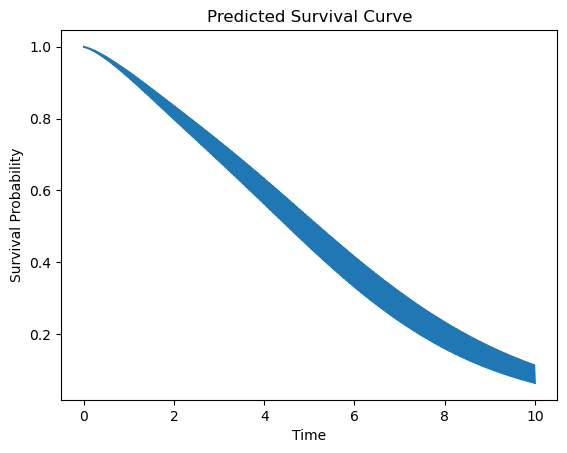

In [195]:
import matplotlib.pyplot as plt

plt.plot(surv_df["time"], surv_df["surv"])
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Curve")
plt.show()



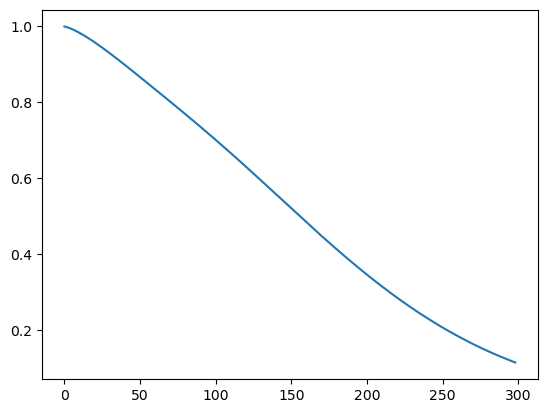

In [164]:
surv = np.array(surv_pred)
time = np.arange(len(surv))  # or define actual times

plt.plot(time, surv);

In [165]:
ro.r.plot(fp_model, newdata=new_data, type="surv")


,Estimate,lower,upper
1,0.998915,0.995175,0.999756
2,0.997886,0.992938,0.999368
3,0.996651,0.990701,0.998796
4,0.995245,0.988428,0.998050
5,0.993692,0.986105,0.997142
...,...,...,...
295,0.121048,0.072996,0.182041
296,0.119485,0.071702,0.180352
297,0.117938,0.070425,0.178675
298,0.116406,0.069165,0.177012
